<a href="https://colab.research.google.com/github/heesukjang/W266_NLP_With_DeepLearning/blob/main/Multiclass_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3: Fine tuning a multiclass classification BERT model

**Description:** This assignment covers fine-tuning of a multiclass classification. You will compare two different types of solutions using BERT-based models. You should also be able to develop an intuition for:


* Working with BERT
* Using multiple models to focus on different sub-tasks
* Different metrics to measure the effectiveness of your model



The assignment notebook closely follows the lesson notebooks. We will use the 20 newsgroups dataset and will leverage some of the models, or part of the code, for our current investigation. 

**You are strongly encouraged to read through the entire notebook before answering any questions or writing any code.**

The initial part of the notebook is purely setup. We will then generate our BERT model and see if and how we can improve it. 

Do not try to run this entire notebook on your GCP instance as the training of models requires a GPU to work in a timely fashion. This notebook should be run on a Google Colab leveraging a GPU. By default, when you open the notebook in Colab it will try to use a GPU. Total runtime of the entire notebook (with solutions and a Colab GPU) should be about 1h.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/datasci-w266/2023-spring-main/blob/master/assignment/a3/Multiclass_text_classification.ipynb)

The overall assignment structure is as follows:

1. Setup
  
  1.1 Libraries & Helper Functions

  1.2 Data Acquisition

  1.3 Training/Test/Validation Sets for BERT-based models

2. Classification with a fine tuned BERT model

  2.1 Create the specified BERT model
  
  2.2 Fine tune the BERT model as directed

  2.3 Examine the predictions with various metrics

3. Classification using two stages

  3.1 Relabel the data to group the often confused classes

  3.2 Train the first stage model on the relabeled data

  3.3 Separate the data for just the confused classes

  3.4. Train the second stage model on the two classes

  3.5. Combine and evaluate the predictions from the two stages

4. Look at examples of misclassifications, see what might have changed



**INSTRUCTIONS:**: 

* Questions are always indicated as **QUESTION:**, so you can search for this string to make sure you answered all of the questions. You are expected to fill out, run, and submit this notebook, as well as to answer the questions in the **answers** file as you did in a1 and a2.

* **### YOUR CODE HERE** indicates that you are supposed to write code.

* If you want to, you can run all of the cells in section 1 in bulk. This is setup work and no questions are in there. At the end of section 1 we will state all of the relevant variables that were defined and created in section 1.

* **IMPORTANT NOTE:** Because the data we're using is downloaded each time we run section 1, a different split of train, validation, and test records is created.  This means that the accuracy, precision, recall, and F1 scores will change, although the delta will be small.  Please enter the values from your final run so that the answer values in your answers file correspond to the answer values in the outputs in your notebook.


### 1. Setup

Lets get all our libraries and download and process our data.

In [2]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 62.4 MB/s eta 0:00:00


In [3]:
!pip install pydot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [5]:
from collections import Counter
import numpy as np
import tensorflow as tf
from tensorflow import keras

import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint 

In [6]:
from transformers import BertTokenizer, TFBertModel

### Text Classification (Name Entity Tagging) with BERT (QUESTION ???)
[The 20 newsgroups text dataset](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html)

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon a messages posted before and after a specific date.

This module contains two loaders. The first one, sklearn.datasets.**fetch_20newsgroups**, <u>returns a list of the raw texts</u> that can be fed to text feature extractors such as sklearn.feature_extraction.text.CountVectorizer with custom parameters so as to extract feature vectors. The second one, sklearn.datasets.fetch_20newsgroups_vectorized, returns ready-to-use features, i.e., it is not necessary to use a feature extractor.

In [7]:
def read_20newsgroups(test_size=0.1):
  # download & load 20newsgroups dataset from sklearn's repos
  dataset = fetch_20newsgroups(subset="all", shuffle=True, remove=("headers", "footers", "quotes"))
  documents = dataset.data
  labels = dataset.target
  # split into training & testing a return data as well as label names
  return train_test_split(documents, labels, test_size=test_size), dataset.target_names
  
# call the function
(train_texts, test_texts, train_labels, test_labels), target_names = read_20newsgroups()

Take a look at the records.  We basically have a long string of text and an associated label.  That label is the Usenet group where the posting occured. The records are the raw text.  They vary significantly in size.

In [8]:
train_texts[:2]

["\nHow can a witness tell that someone in a burning truck is dead rather than\nunconscious?\n\n\nWhat kind of witnesses?  If we are talking about witnesses who were at\nthe accident, or were otherwise directly involved (e.g., paramedics,\nemergency room doctors, etc.), then they should have been used at the\nfirst trial.  You don't get a new trial because you screwed up and\nforgot to call all of your witnesses.\n\nIf we are talking about new expert witnesses who will offer new\ninterpretations of the data, note that the loser can *ALWAYS* find\nsuch witnesses.  If this were grounds for a new trial, then the loser\ncould *ALWAYS* get a new trial, and keep doing so until the loser\nbecomes a winner (and then the other side would come up with new\nexpert witnesses).",
 "\n\nIt always amazes me how quick people are to blame whatever\nadministration is current for things they couldn't possibly have\ninitiated.  This chip had to take *years* to develop, yet already\nwe're claiming that the

Notice the "labels" are just integers that are an offset into the list of target names. (QUESTION: NOT UNDERSTANDING)

In [9]:
# the 1st raw text is labeled as "rec.autos" at index 7 
# the 2nd raw text is labeled as "talk.politics.mideast" at index 17 ??? 
train_labels[:2]

array([18, 11])

The variable ''target_names'' stores all of the names of the labels.

In [10]:
print(target_names)

for idx, val in enumerate(target_names[:20]):
  print(idx, val)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
0 alt.atheism
1 comp.graphics
2 comp.os.ms-windows.misc
3 comp.sys.ibm.pc.hardware
4 comp.sys.mac.hardware
5 comp.windows.x
6 misc.forsale
7 rec.autos
8 rec.motorcycles
9 rec.sport.baseball
10 rec.sport.hockey
11 sci.crypt
12 sci.electronics
13 sci.med
14 sci.space
15 soc.religion.christian
16 talk.politics.guns
17 talk.politics.mideast
18 talk.politics.misc
19 talk.religion.misc


We already have a test set and a train set.  Let's explicitly set aside part of our training set for validation purposes. (split the given training further into training and validation set) 

In [11]:
print(f'len(train_texts) = {len(train_texts)}')
valid_texts = train_texts[16000:]
valid_labels = train_labels[16000:]     # set about 5% of the total training set to be validation set
train_texts = train_texts[:16000]
train_labels = train_labels[:16000]

print(f'len(valid_texts) = {len(valid_texts)}\nlen(valid_labels) = {len(valid_labels)}')
print(f'len(train_texts) = {len(train_labels)}\nlen(train_texts) = {len(train_labels)}')

len(train_texts) = 16961
len(valid_texts) = 961
len(valid_labels) = 961
len(train_texts) = 16000
len(train_texts) = 16000


The validation set will always have 961 records.

In [12]:
len(valid_texts)

961

The training set will always have 16000 records.

In [13]:
len(train_texts)

16000

**NOTE:** Each time you rerun the data you will draw a *different* set of train and test documents even though the numbers 961 and 16000 will always be the same.

In [14]:
#get the labels in a needed data format for validation
npvalid_labels = np.asarray(valid_labels)   
print(len(npvalid_labels), npvalid_labels[:10])

961 [17 12  6 17 14  7  9  7  6  6]


* train_texts - an array of text strings for training
* test_texts - an array of text strings for testing 
* valid texts - an array of text strings for validation
* train_labels - an array of integers representing the labels associated with train_texts
* test_labels - an array of integers representing the labels associated with test_texts
* valid_labels - an array of integers representing the labels associated with valid_texts
* target_names - an array of label strings that correspond to the integers in the *_labels arrays

### 2. Classification with a fine tuned BERT model

Let's pick our BERT model.  We'll start with the base BERT model and we'll use the cased version since our data has capital and lower case letters.

In [15]:
#make it easier to use a variety of BERT subword models
model_checkpoint = 'bert-base-cased'   # case sensitive (care about upper and lower case)

In [16]:
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


We're setting our maximum training record length to 200.  BERT models can handle more and after you've completed the assignment you're welcome to try larger and small sized records.

In [17]:
max_length = 200

Now we'll tokenize our three data slices.  This will take a minute or two.

In [18]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length` and return a tf Tensor
train_encodings = bert_tokenizer(train_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings = bert_tokenizer(test_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')

Notice our input_ids for the first training record and their padding. The train_encodings also includes an array of token_type_ids and an attention_mask array. 

In [19]:
print('len(train_encodings.input_ids[:1]) = ',len(train_encodings.input_ids[:1]), '\ntrain_encodings.input_ids[:1]',train_encodings.input_ids[:1])

len(train_encodings.input_ids[:1]) =  1 
train_encodings.input_ids[:1] tf.Tensor(
[[  101  1731  1169   170  7737  1587  1115  1800  1107   170  4968  4202
   1110  2044  1897  1190  9719   136  1327  1912  1104 10313   136  1409
   1195  1132  2520  1164 10313  1150  1127  1120  1103  4216   117  1137
   1127  4303  2626  2017   113   174   119   176   119   117 18311  4611
   4724   117  5241  1395  8114   117  3576   119   114   117  1173  1152
   1431  1138  1151  1215  1120  1103  1148  3443   119  1192  1274   112
    189  1243   170  1207  3443  1272  1128 15020  1146  1105  9424  1106
   1840  1155  1104  1240 10313   119  1409  1195  1132  2520  1164  1207
   6640 10313  1150  1209  2906  1207 17555  1104  1103  2233   117  3805
   1115  1103 19398  1169   115 18589 11840  3663  1708   115  1525  1216
  10313   119  1409  1142  1127  4745  1111   170  1207  3443   117  1173
   1103 19398  1180   115 18589 11840  3663  1708   115  1243   170  1207
   3443   117  1105  1712  183

### Write a function to **create this multiclass bert model**.

Keep in mind the following:
* Each record can have one of n labels where **n = the size of target_names**.
* We'll still want a **hidden size layer of size 201**
* We'll want our hidden layer to make use of the **pooler output** from BERT
* We'll also want to use **dropout**
* Our **classification layer** will need to be appropriately sized and use the correct non-linearity for a multi-class problem.
* Since we have multiple labels we can no longer use binary cross entropy.  Instead we need to change our loss metric to a **categorical cross entropy (one-hot encoding based loss)**.  Which of the two categorical cross entropy metrics will work best here? 
* Make sure that training affects **all** of the layers in BERT.


[metrics=SparseCategoricalCrossentropy()](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/SparseCategoricalCrossentropy)<br>
Computes the crossentropy metric between thh labels and predictions **(integer-based loss)**. Cross entropy loss is a metric used to measure how well a classification model in machine learning performs. The loss (or error) is measured as a number between 0 and 1, with 0 being a perfect model. The goal is generally to get your model as close to 0 as possible

[metrics=tf.keras.metrics.Accuracy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy)<br>Calculates how often predictions equal labels.

[metrics=tf.keras.metrics.SparseCategoricalAccuracy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/SparseCategoricalAccuracy)<br>
Computes how often predictions match integer labels.

In [47]:
# we want to use "sparse_categorical_crossentropy (integer-based loss function)" 
#   compared to just "categorial_crossentropy (one-hot encoding based loss i.e.)"
from keras.utils.layer_utils import count_params

def create_bert_multiclass_model(checkpoint = model_checkpoint,
                                 num_classes = 20,
                                 hidden_size = 201, 
                                 dropout=0.3,
                                 learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
    """
    bert_model = TFBertModel.from_pretrained(checkpoint)                                              

    ### YOUR CODE HERE
    bert_model.trainable = True     # Make sure that training affects all of the layers in BERT.

    input_ids = tf.keras.layers.Input(shape=(200,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(200,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(200,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)
    pooler_output = bert_out[1]    # one vector for each 
    
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_output)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden)    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),          # A 'sigmoid' activation layer turns the output "logit" into a value, 0-1 
                                 metrics='accuracy')  
                                #  metrics=tf.keras.metrics.SparseCategoricalAccuracy())    # QUESTION: which metrics ???
    ### END YOUR CODE
    return classification_model

In [48]:
pooler_bert_model = create_bert_multiclass_model(checkpoint=model_checkpoint, num_classes=20)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [49]:
pooler_bert_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 200)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 200)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 200)]       0           []                               
 er)                                                                                              
                                                                                            

**Param # = Total params** (QUESTION ???)
**Total params = Trainable params: 108,468,881** = 108,310,272 + 154,569 + 4,040

**QUESTION:** 2.1 How many trainable parameters are in your dense hidden layer? **154,569**

**QUESTION:** 2.2 How many trainable parameters are in your classification layer? **4,040**

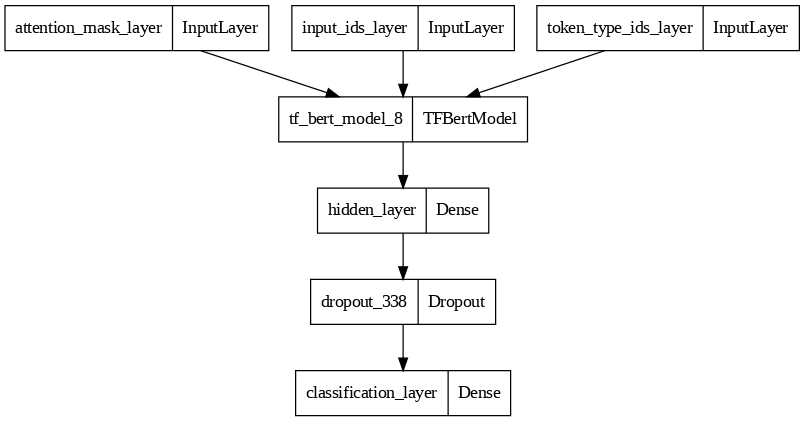

In [42]:
keras.utils.plot_model(pooler_bert_model, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90)

In [50]:
# It takes 10 to 14 minutes to complete an epoch when using a GPU
pooler_bert_model_history = pooler_bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
                                                  train_labels,   
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], 
                                                  npvalid_labels),    
                                                  batch_size=8, 
                                                  epochs=1)  

2000/2000 [==============================] - 737s 350ms/step - loss: 1.4130 - accuracy: 0.5789 - val_loss: 1.0656 - val_accuracy: 0.6868


Now we need to run evaluate against our fine-tuned model.  This will give us an overall accuracy based on the test set.

In [51]:
#batch 8, ML=201
score = pooler_bert_model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask], 
                                                  test_labels) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

59/59 [==============================] - 27s 456ms/step - loss: 1.0542 - accuracy: 0.6897
Test loss: 1.0541508197784424
Test accuracy: 0.6896551847457886


**QUESTION:** 2.3 What is the Test accuracy score you get from your model? (Just copy and paste the value into the answers sheet and round to five significant digits.)  **0.68966**

In [52]:
#run predict for the first three elements in the test data set
predictions = pooler_bert_model.predict([test_encodings.input_ids[:3], test_encodings.token_type_ids[:3], test_encodings.attention_mask[:3]])

1/1 [==============================] - 3s 3s/step


In [53]:
predictions

array([[1.02119008e-03, 1.37795536e-02, 3.56133655e-02, 7.74612546e-01,
        1.46560371e-01, 1.11214817e-03, 3.94385122e-03, 9.50994960e-04,
        1.22523401e-03, 5.34771185e-04, 2.68520060e-04, 1.77545764e-03,
        1.42306965e-02, 3.89673369e-04, 1.85581774e-03, 3.65000655e-04,
        3.57090234e-04, 5.60095534e-04, 5.84437570e-04, 2.59121065e-04],
       [4.09397413e-04, 6.42091036e-04, 2.09731763e-04, 8.92647426e-04,
        2.43791539e-04, 1.27451005e-03, 2.99181417e-03, 3.11322947e-04,
        4.43969527e-03, 5.25243254e-03, 9.78576362e-01, 2.58421409e-04,
        2.08545150e-03, 5.04389172e-04, 3.85877123e-04, 2.55680963e-04,
        5.11162216e-04, 2.56251427e-04, 2.76644307e-04, 2.22415663e-04],
       [3.46331217e-04, 9.57428873e-01, 7.50749186e-03, 3.22073721e-03,
        1.45518815e-03, 1.87075567e-02, 1.11044885e-03, 1.05767889e-04,
        1.21344347e-03, 8.08701268e-04, 1.83924436e-04, 1.36235321e-03,
        3.70034203e-03, 6.10669143e-04, 7.62588053e-04, 2.4994

In [54]:
#run and capture all predictions from our test set using model.predict
### YOUR CODE HERE
predictions_model1 = pooler_bert_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
### END YOUR CODE

#now we need to get the highest probability in the distribution for each prediction
#and store that in a tf.Tensor
predictions_model1 = tf.argmax(predictions_model1, axis=-1)
predictions_model1

59/59 [==============================] - 28s 464ms/step


<tf.Tensor: shape=(1885,), dtype=int64, numpy=array([ 3, 10,  1, ...,  6, 15, 15])>

There are two ways to see what's going on with our classifier.  Overall accuracy is interesting but it can be misleading.  We need to make sure that each of our categories' prediction performance is operating at an equal or higher level than the overall.

Here we'll use the classification report from scikit learn.  It expects two inputs as arrays.  One is the ground truth (y_true) and the other is the associated prediction (y_pred).  This is based on gethering all the predictions from our our test set.

[Classification Report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)<br>
[Difference between macro avg precision and Weighted avg precision](https://www.mariakhalusova.com/posts/2019-04-17-ml-model-evaluation-metrics-p2/#:~:text=Macro%2Daveraged%3A%20all%20classes%20equally,is%20weighted%20by%20its%20size)
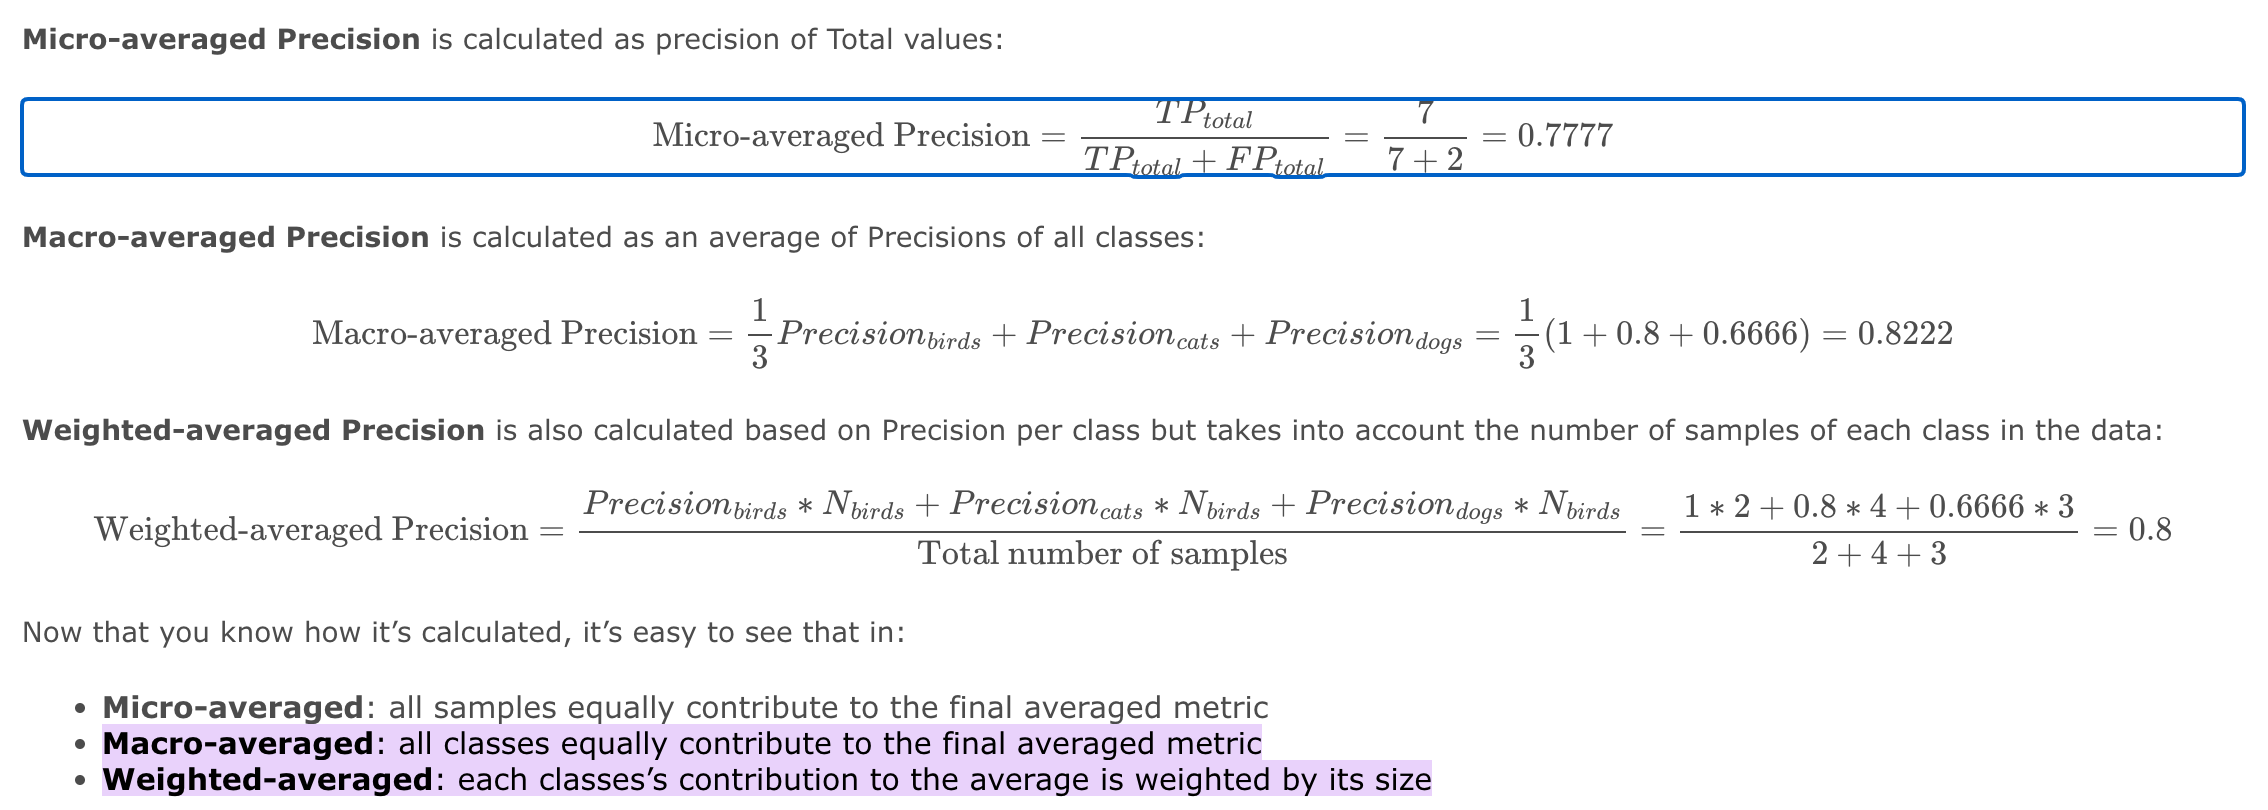

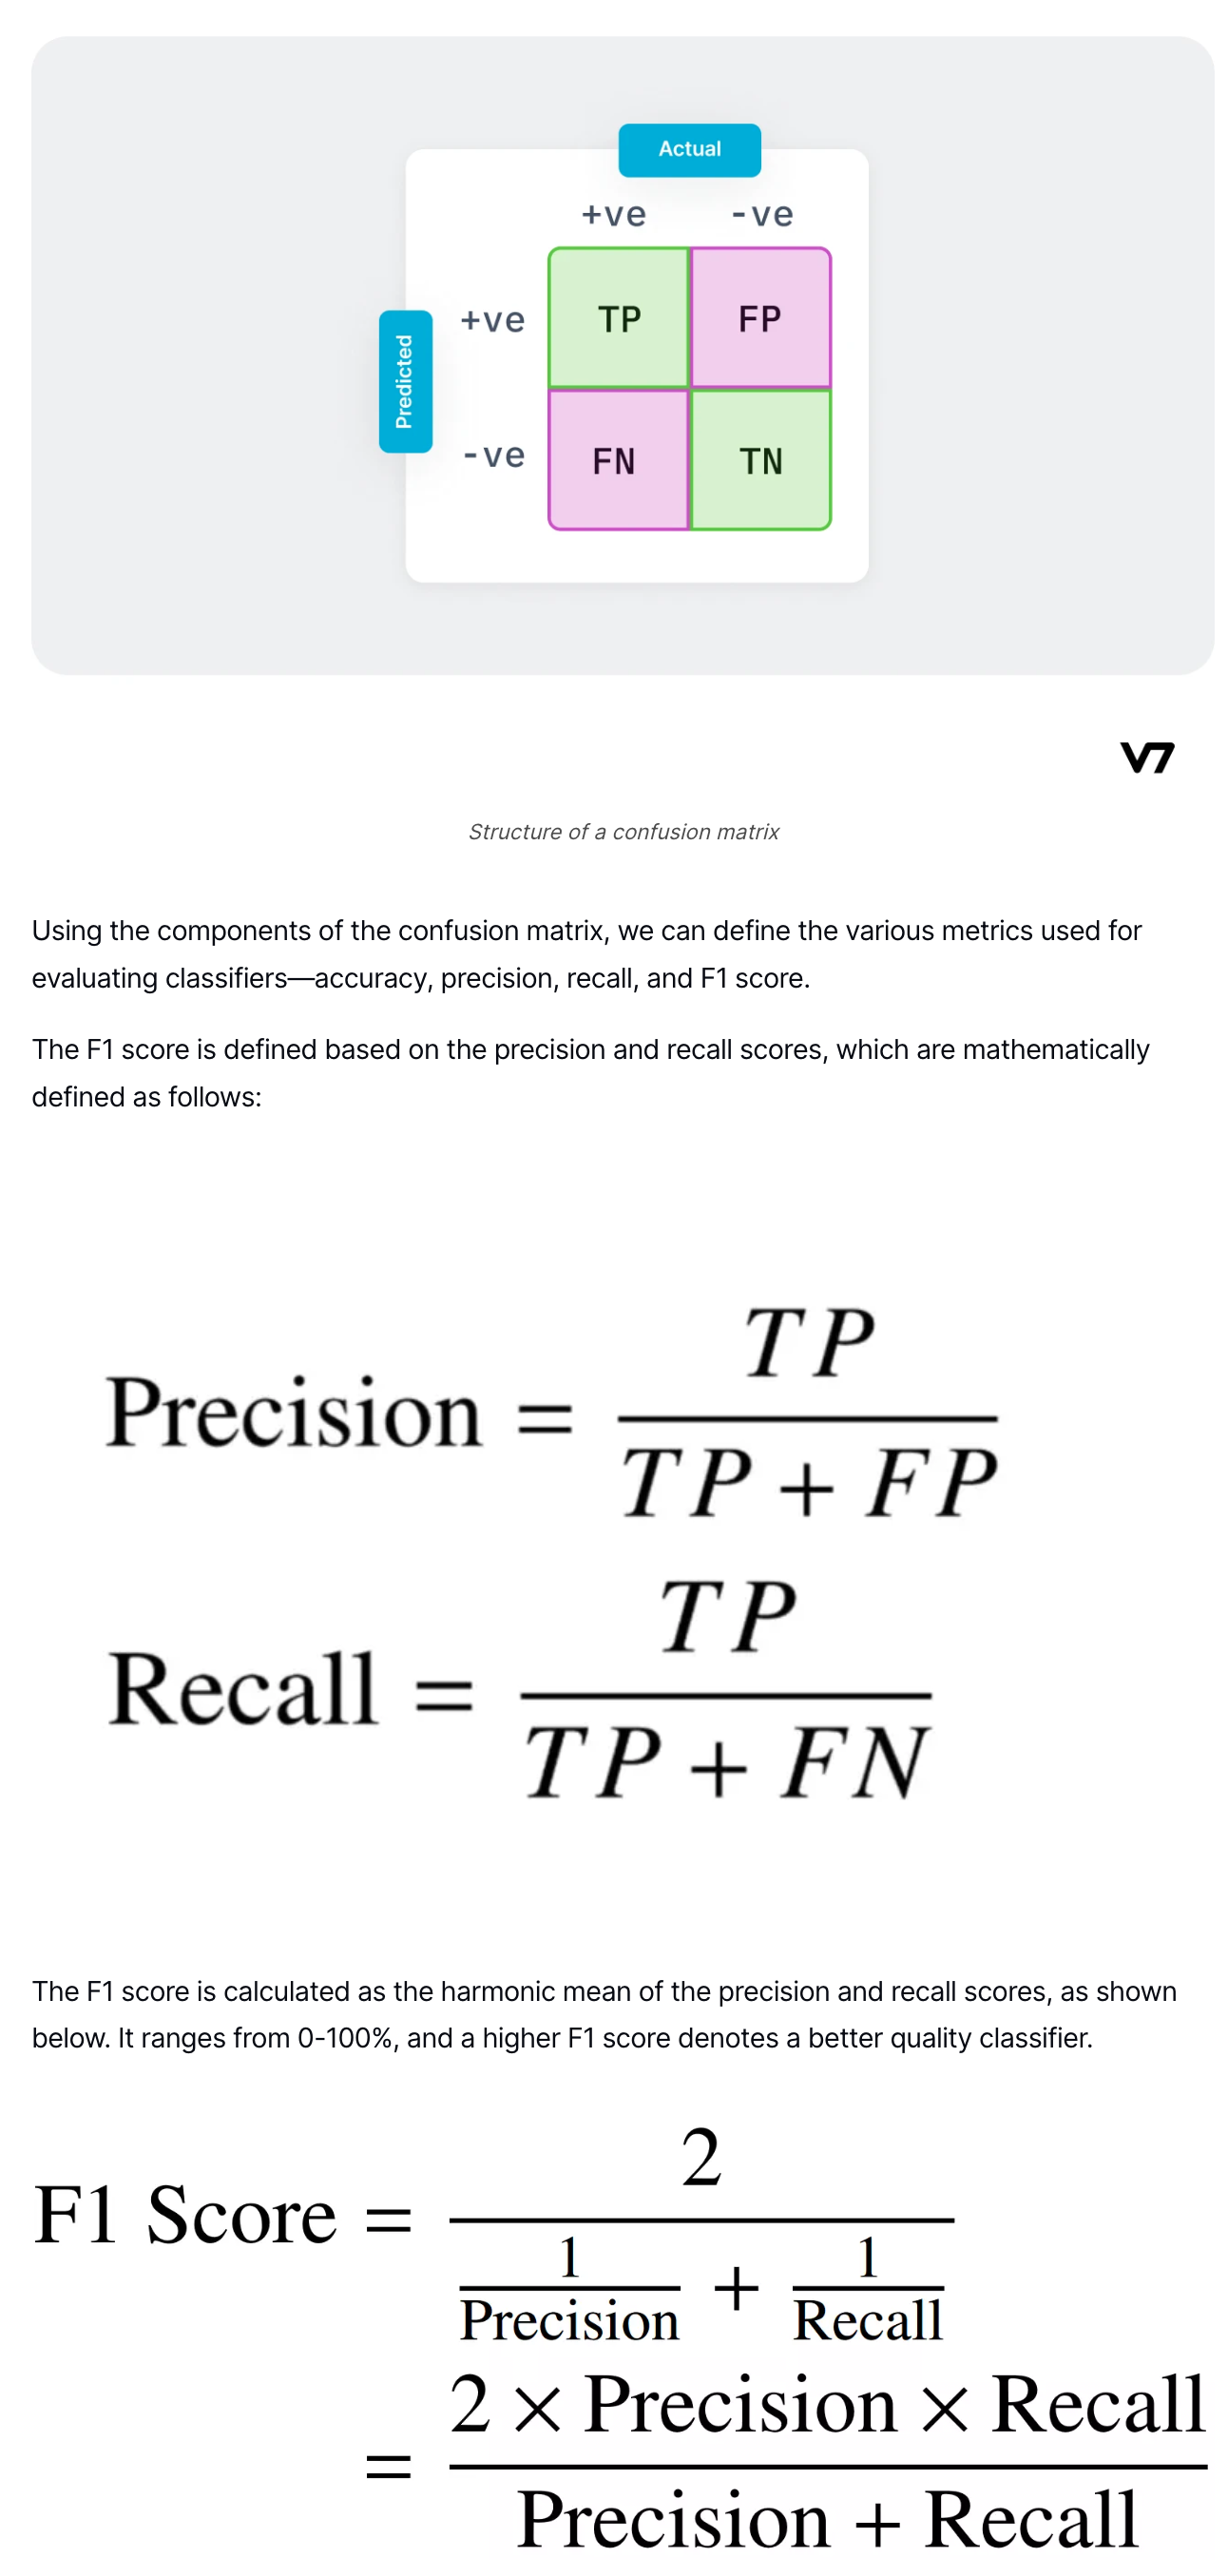

In [55]:
print(classification_report(test_labels, predictions_model1.numpy(), target_names=target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.53      0.24      0.33        78
           comp.graphics       0.57      0.75      0.65        92
 comp.os.ms-windows.misc       0.60      0.60      0.60        97
comp.sys.ibm.pc.hardware       0.55      0.72      0.62        93
   comp.sys.mac.hardware       0.83      0.60      0.70       105
          comp.windows.x       0.93      0.69      0.79        97
            misc.forsale       0.86      0.76      0.81        89
               rec.autos       0.69      0.66      0.68        89
         rec.motorcycles       0.80      0.70      0.75       103
      rec.sport.baseball       0.94      0.85      0.89       103
        rec.sport.hockey       0.89      0.82      0.85        99
               sci.crypt       0.82      0.77      0.79       110
         sci.electronics       0.50      0.66      0.57        88
                 sci.med       0.83      0.82      0.82       115
         

**QUESTION:** 2.4 What is the key difference between the macro average F1 score and the weighted average F1 score? **The weighted avg accounts for imbalance in the labels.**

**QUESTION:** 2.5 What is the macro average F1 score you get from the classification report?  **0.66**

Now we'll generate another very valuable visualization of what's happening with our classifier -- a confusion matrix.

In [57]:
cm = tf.math.confusion_matrix(test_labels, predictions_model1)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

And now we'll display it!

Text(159.0, 0.5, 'True')

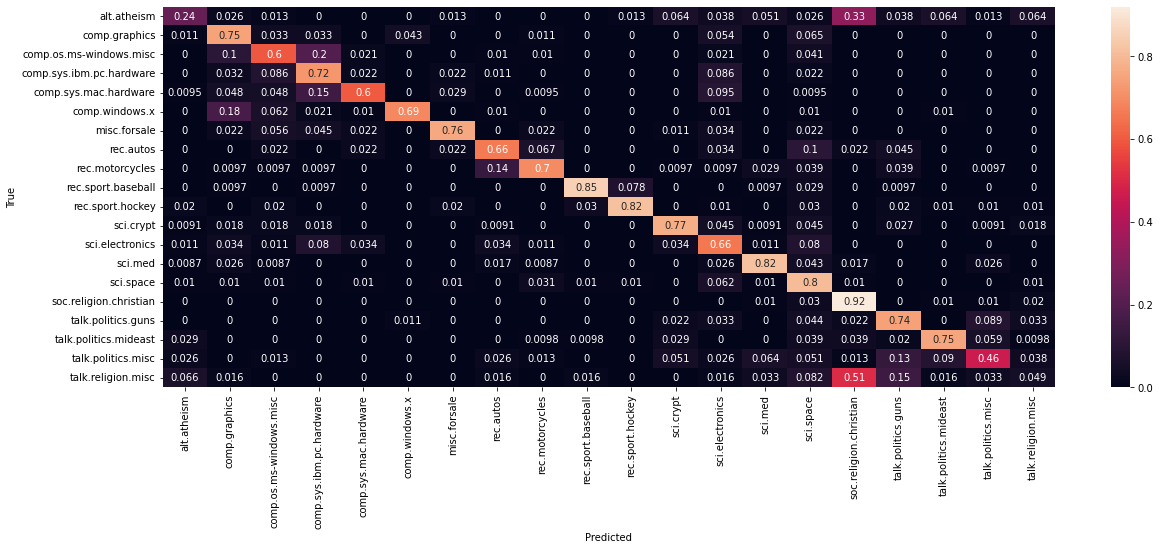

In [58]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")

### 3. Classification using two stages

Okay, not bad.  As you can see, some categories are easier to distinguish than others. Look for the class with the lowest F1 score (it should be the one at the bottom of the list). In the confusion matrix, which other class is that one being mistaken for most often?

You might notice that the categories in this dataset are somewhat heirarchical. There are more obvious differences between groups of news categories (e.g. computers vs recreation) and then subtler differences between categories within those groups (e.g. PC vs Mac, within computers).

When this happens, one idea is to train a series of models, to first separate out the more obvious groups of classes, and then use more specialized sub-models to classify only a subset of the classes. Let's try that here.

#### Step 1: New model with 19 classes

For simplicity, we'll just combine two categories in our first step. We'll replace the label of the last class with the label of the class it's most often mistaken for. (That way, we'll have labels from 0 to 18 instead of 0 to 19, and don't have to renumber everything, though you would have to if you group them more.)

In [59]:
label_to_replace = 19

# label_to_replace_with = ...
### YOUR CODE HERE
label_to_replace_with

### END YOUR CODE

train_labels_19class = train_labels.copy()
train_labels_19class[train_labels_19class == label_to_replace] = label_to_replace_with

valid_labels_19class = npvalid_labels.copy()
valid_labels_19class[valid_labels_19class == label_to_replace] = label_to_replace_with

test_labels_19class = test_labels.copy()
test_labels_19class[test_labels_19class == label_to_replace] = label_to_replace_with

NameError: ignored

Now let's create a new model with the same architecture, but to predict probabilities for 19 classes instead of 20. We're using all of the data in this first step, so we'll use the encodings we already preprocessed as inputs, but use the new labels that only have 19 classes.

In [ ]:
bert_model_19class = create_bert_multiclass_model(checkpoint = model_checkpoint, num_classes=19)

In [ ]:
bert_model_19class_history = bert_model_19class.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
                                                  train_labels_19class,   
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask],
                                                                   valid_labels_19class),    
                                                  batch_size=8,
                                                  epochs=1)

In [ ]:
#Evaluate the fine tuned 19-class model against the test data with 19-class labels
### YOUR CODE HERE
### END YOUR CODE
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

**QUESTION:** 

3.1 What is the test accuracy you get when you run the new first stage model with only 19 classes?


In [ ]:
#run and capture all the predictions from the 19 class data
### YOUR CODE HERE 
### END YOUR CODE

predictions_19class

In [ ]:
target_names_19class = target_names[:label_to_replace_with] \
                     + ['** COMBINED CLASS **'] \
                     + target_names[label_to_replace_with+1:19]

print(classification_report(test_labels_19class, predictions_19class.numpy(),
                            target_names=target_names_19class))

**QUESTION:** 

3.2 What is the F1 score you get for the combined class when you run the new first stage model with only 19 classes?


#### Step 2: New model with only the two classes combined in step one

Now, our first stage model is able to determine which text is one of the two often confused classes, but we need to train a more specific model to distinguish between just these two classes. Ideally, this model will only focus on the more subtle differences between these two news categories, since it doesn't have to learn everything else about the other categories.

For this model, we're only going to train using the text examples that are one of the two confused categories. We'll keep the encodings we already tokenized, so we need to separate out the input_ids, token_type_ids, and attention_mask for just the rows that have one of these two labels.

In [ ]:
train_mask_2class = (train_labels_19class == label_to_replace_with)
train_encodings_2class = {'input_ids': train_encodings.input_ids[train_mask_2class],
                          'token_type_ids': train_encodings.token_type_ids[train_mask_2class],
                          'attention_mask': train_encodings.attention_mask[train_mask_2class]}
train_labels_2class = train_labels.copy()[train_mask_2class]
train_labels_2class = (train_labels_2class == label_to_replace_with).astype(int)

valid_mask_2class = (valid_labels_19class == label_to_replace_with)
valid_encodings_2class = {'input_ids': valid_encodings.input_ids[valid_mask_2class],
                          'token_type_ids': valid_encodings.token_type_ids[valid_mask_2class],
                          'attention_mask': valid_encodings.attention_mask[valid_mask_2class]}
valid_labels_2class = npvalid_labels.copy()[valid_mask_2class]
valid_labels_2class = (valid_labels_2class == label_to_replace_with).astype(int)

test_mask_2class = (test_labels_19class == label_to_replace_with)
test_encodings_2class = {'input_ids': test_encodings.input_ids[test_mask_2class],
                          'token_type_ids': test_encodings.token_type_ids[test_mask_2class],
                          'attention_mask': test_encodings.attention_mask[test_mask_2class]}
test_labels_2class = test_labels.copy()[test_mask_2class]
test_labels_2class = (test_labels_2class == label_to_replace_with).astype(int)

In [ ]:
train_labels_2class.shape

In [ ]:
train_labels_2class

Create and train a new model with the same architecture as before, except that it only predicts two classes. (Note that we could change this to a binary prediction model, but we'll keep it multiclass for consistency here.)

In [ ]:
bert_model_2class = create_bert_multiclass_model(checkpoint=model_checkpoint, num_classes=2)

In [ ]:
bert_model_2class_history = bert_model_2class.fit([train_encodings_2class['input_ids'],
                                                   train_encodings_2class['token_type_ids'],
                                                   train_encodings_2class['attention_mask']], 
                                                  train_labels_2class,   
                                                  validation_data=([valid_encodings_2class['input_ids'],
                                                                    valid_encodings_2class['token_type_ids'],
                                                                    valid_encodings_2class['attention_mask']],
                                                                   valid_labels_2class),    
                                                  batch_size=8, 
                                                  epochs=1)

In [ ]:
#Evaluate the two-class model against the two-class test set.
### YOUR CODE HERE
### END YOUR CODE
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

In [ ]:
#run and capture all the predictions from the 2-class test data
### YOUR CODE HERE 
### END YOUR CODE
predictions_2class

In [ ]:
# Run the sklearn classification_report again with the 2-class predictions
### YOUR CODE HERE
### END YOUR CODE

**QUESTION:** 

3.3 What is the macro average F1 score you get when you run the new second stage model with only 2 classes?

#### Step 3: Combine the predicted labels from the two steps

To combine our models into two steps, start with the predictions from the first step. Keep all predicted labels except the ones with a predicted value of label_to_replace_with (the label we gave to both of the confused classes in the first step).

Wherever the first model predicted the combined category, we'll replace the predictions with the label from the second model. If we used these models in inference, we'd only send an example to the second model if the first model predicted that it was from the combined class.

In [ ]:
predictions_2class = predictions_2class.numpy()
predictions_2class[predictions_2class == 0] = label_to_replace
predictions_2class[predictions_2class == 1] = label_to_replace_with

In [ ]:
predictions_2steps = predictions_19class.numpy()
predictions_2steps[test_mask_2class] = predictions_2class

predictions_2steps

Now let's look at the classification report and confusion matrix, using the combined predictions from our two step model (compared to the original labels). Did the overall results get better?

In [ ]:
# Run the sklearn classification_report with all 20 classes from the 2-step predictions
### YOUR CODE HERE
### END YOUR CODE

In [ ]:
cm = tf.math.confusion_matrix(test_labels, predictions_2steps)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")

**QUESTION:**

3.4 What is the macro average F1 score you get from the combined two-step model?

3.5 What is the difference in points between the macro weighted F1 score for the original model and the combined two-step model?

3.6 What is the new F1 score for the last category (i.e. label_to_replace, the one that had the lowest F1 score in the original model)?

3.7 What is the new F1 score for the other category that you combined with the last category in the two-step model (i.e. label_to_replace_with)?

3.8 Which metric (precision or recall) is now lower for the other category (i.e. label_to_replace_with)?

### Look at examples of misclassifications

What happened in the two-step model? Did everything improve, or did something get worse? We were concerned about the last news category, which had a very low F1 score in the original model. In the two-step model, the F1 score for that category should have gone up.

But for the other category that the original model often confused with the last category, the F1 score might have gone down. In particular, one of the two component metrics, precision or recall, probably went down. (We ask you which one went down in question 3.7 above.)

We might be able to tell what happened from the confusion matrix, but it's also always a good idea to look at actual examples that were misclassified, to see if we can spot any patterns. We can also isolate more specific examples, like test examples that the original model got right, but the two-step model got wrong. Let's do that below.

**CRITICAL NOTE:**  If nothing prints out when you run the code below, there are two possibilities.  The first is that there is some error in the code or variable names you have created in earlier cells.  The second possibility is that given your current train, validation, and test split, the second model predicted the "label_to_replace_with" class and the first model did so too.  This is unlikely but it is possible. In either case, you must go back and re-run the *ENTIRE* notebook to make sure you get a new train, validation, and test split which will allow you to observe the first and second models disagreeing. Please make sure you enter the metric values from this new run into your answers file.

In [ ]:
# Make a vector the length of our test set, with 1 if the second model predicted the
# "label_to_replace_with" class, and 0s otherwise
select_predictions = (predictions_2steps == label_to_replace_with)


In [ ]:
# Now only keep a 1 if that was not the correct label, i.e. it was a false positive
select_predictions = select_predictions * (test_labels != label_to_replace_with)

In [ ]:
# And now only keep a 1 if the original model predicted the correct label instead
select_predictions = select_predictions * (test_labels == predictions_model1.numpy())

In [ ]:
# Print out the original and clean text of the examples that met the above conditions
for i in np.where(select_predictions)[0]:

    print('Prediction: model1 = %s, model2 = %s):\nText: %s\n\n' %
          (target_names[predictions_model1[i]],
           target_names[predictions_2steps[i]],
           test_texts[i][:1000].replace('\n', ' ')))

**QUESTION:** 

4.1 Why do you think the two-step model got these examples wrong, when the original model got them right?

- A. The two-step model saw less examples of the "label_to_replace" class, because we replaced them with the "label_to_replace_with" examples. So it didn't learn the kind of text in that class as well as the original model.

- B. In the two-step process, the step 1 model overpredicted the combined class, and the step 2 model overpredicted the "label_to_replace_with" class. A third class is now getting mistaken more often for the "label_to_replace_with" class, than in the original model.

- C. It's probably just random that the original model got these specific examples right and the two-step model got them wrong.



4.2 Is there anything you might try next, to try to make the two-step model better?

- A. Try to balance the training data across classes at each step, or add class weights when calling model.fit.

- B. Try to combine another similar category with the two easily confused ones, for a step 1 model with 18 classes and the step 2 model with 3 classes.

- C. Try both A and B